# submission model 2

Train label distribution preview (coarse): {'numbers': 17, 'arithmetic': 9, 'polynomials': 8, 'algebra': 8, 'comparison': 8, 'calculus': 2, 'measurement': 2, 'probability': 2}
Interpolate label distribution preview (coarse): {'numbers': 17, 'arithmetic': 9, 'comparison': 8, 'polynomials': 8, 'algebra': 8, 'measurement': 2, 'calculus': 2, 'probability': 2}
Extrapolate label distribution preview (coarse): {'arithmetic': 6, 'comparison': 3, 'probability': 2, 'numbers': 2, 'algebra': 1, 'measurement': 1}
Interpolate unknown classes count: 0
Extrapolate unknown classes count: 0

Classification report on interpolate set (known classes only):
              precision    recall  f1-score   support

     algebra       1.00      1.00      1.00         8
  arithmetic       1.00      0.78      0.88         9
    calculus       0.00      0.00      0.00         2
  comparison       1.00      1.00      1.00         8
 measurement       0.00      0.00      0.00         2
     numbers       0.68      1.

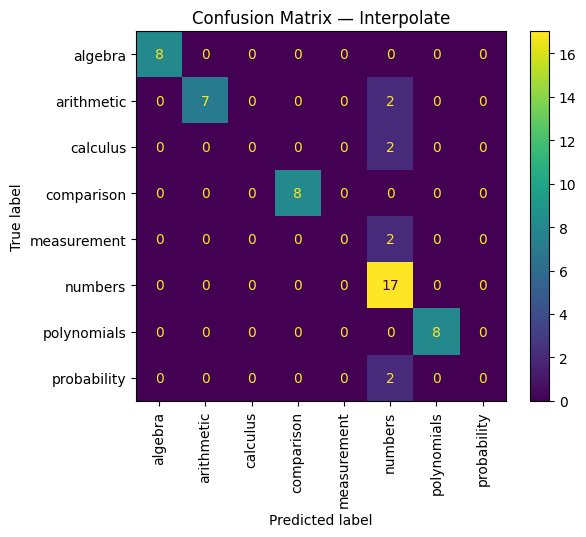


Classification report on extrapolate set (known classes only):
              precision    recall  f1-score   support

     algebra       1.00      1.00      1.00         1
  arithmetic       1.00      0.83      0.91         6
  comparison       1.00      1.00      1.00         3
 measurement       0.00      0.00      0.00         1
     numbers       0.33      1.00      0.50         2
 probability       0.00      0.00      0.00         2

    accuracy                           0.73        15
   macro avg       0.56      0.64      0.57        15
weighted avg       0.71      0.73      0.70        15



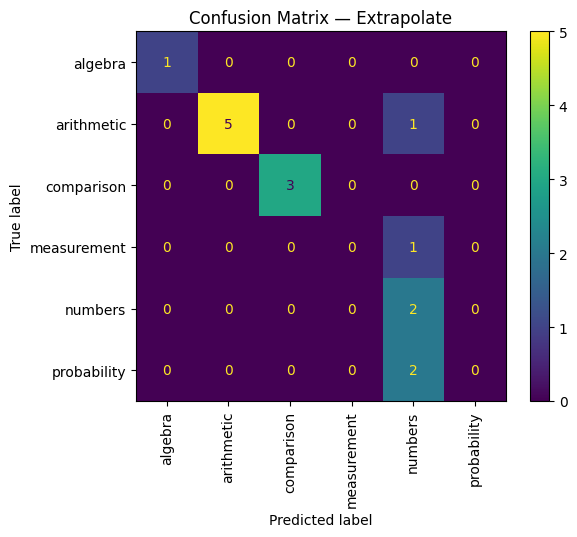

'\nparam_grid = {\n    \'select__k\': [3000, 5000, 7000],\n    \'clf__C\': [0.1, 1.0, 10]\n}\nfrom sklearn.model_selection import KFold, GridSearchCV\n\ncv = KFold(n_splits=3, shuffle=True, random_state=578)\ngrid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=\'f1_macro\', n_jobs=-1)\n\ngrid.fit(train_docs, y_train)\n\nprint("\nBest parameters from tuning:", grid.best_params_)\nprint("Best CV score from tuning:", grid.best_score_)\n\n# You can also evaluate grid.best_estimator_ similarly to pipeline\n'

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

np.random.seed(578)

# --- Helper functions ---

def load_docs_and_labels(paths):
    docs = []
    labels = []
    for path in paths:
        with open(path, encoding="utf-8") as f:
            content = f.read().strip()
            docs.append(content)
        filename = os.path.basename(path)
        label = os.path.splitext(filename)[0]
        labels.append(label)
    return docs, labels

def preview_counter(counter_obj, n=10):
    return dict(counter_obj.most_common(n))

def extract_coarse_label(label):
    return label.split("__")[0]

def safe_transform(labels, le):
    known_classes = set(le.classes_)
    new_labels = []
    unknown_count = 0
    for label in labels:
        if label in known_classes:
            new_labels.append(le.transform([label])[0])
        else:
            new_labels.append(-1)
            unknown_count += 1
    return np.array(new_labels), unknown_count

# --- File paths ---
train_paths = glob.glob("math/train-medium/*.txt")
inter_paths = glob.glob("math/interpolate/*.txt")
extra_paths = glob.glob("math/extrapolate/*.txt")

train_docs, train_labels = load_docs_and_labels(train_paths)
inter_docs, inter_labels = load_docs_and_labels(inter_paths)
extra_docs, extra_labels = load_docs_and_labels(extra_paths)

# --- Map categorical features to main math subject areas ---
train_labels_coarse = [extract_coarse_label(lab) for lab in train_labels]
inter_labels_coarse = [extract_coarse_label(lab) for lab in inter_labels]
extra_labels_coarse = [extract_coarse_label(lab) for lab in extra_labels]

# --- Preview feature distributions ---
print("Train label distribution preview (coarse):", preview_counter(collections.Counter(train_labels_coarse)))
print("Interpolate label distribution preview (coarse):", preview_counter(collections.Counter(inter_labels_coarse)))
print("Extrapolate label distribution preview (coarse):", preview_counter(collections.Counter(extra_labels_coarse)))

# --- Encode labels ---
le = LabelEncoder()
le.fit(train_labels_coarse)
y_train = le.transform(train_labels_coarse)

y_inter, unknown_count_inter = safe_transform(inter_labels_coarse, le)
print(f"Interpolate unknown classes count: {unknown_count_inter}")

y_extra, unknown_count_extra = safe_transform(extra_labels_coarse, le)
print(f"Extrapolate unknown classes count: {unknown_count_extra}")

# --- Define pipeline ---
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('select', SelectKBest(score_func=chi2, k=5000)),
    ('clf', LogisticRegression(max_iter=1000, C=1.0, random_state=578))
])

# === Main fixed hyperparameter build ===
pipeline.fit(train_docs, y_train)

# --- Evaluate interpolate set ---
mask_inter = y_inter != -1
if np.any(mask_inter):
    y_inter_known = y_inter[mask_inter]
    inter_docs_known = np.array(inter_docs)[mask_inter]
    y_inter_pred = pipeline.predict(inter_docs_known)
    print("\nClassification report on interpolate set (known classes only):")
    print(classification_report(y_inter_known, y_inter_pred, target_names=le.classes_, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_inter_known, y_inter_pred, display_labels=le.classes_, xticks_rotation="vertical")
    plt.title("Confusion Matrix — Interpolate")
    plt.show()
else:
    print("No known classes in interpolate set to evaluate.")

# --- Evaluate extrapolate set ---
mask_extra = y_extra != -1
if np.any(mask_extra):
    y_extra_known = y_extra[mask_extra]
    extra_docs_known = np.array(extra_docs)[mask_extra]
    y_extra_pred = pipeline.predict(extra_docs_known)

    present_labels = np.unique(y_extra_known)
    present_class_names = le.inverse_transform(present_labels)

    print("\nClassification report on extrapolate set (known classes only):")
    print(classification_report(
        y_extra_known, 
        y_extra_pred, 
        labels=present_labels,
        target_names=present_class_names,
        zero_division=0
    ))
    ConfusionMatrixDisplay.from_predictions(
        y_extra_known, 
        y_extra_pred, 
        display_labels=present_class_names,
        xticks_rotation="vertical"
    )
    plt.title("Confusion Matrix — Extrapolate")
    plt.show()
else:
    print("No known classes in extrapolate set to evaluate.")

## hyperparameter tune + test pass

In [ ]:
# === Optional tuning block for separate evaluation ===

param_grid = {
    'select__k': [3000, 5000, 7000],
    'clf__C': [0.1, 1.0, 10]
}
from sklearn.model_selection import KFold, GridSearchCV

cv = KFold(n_splits=3, shuffle=True, random_state=578)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

grid.fit(train_docs, y_train)

print("\nBest parameters from tuning:", grid.best_params_)
print("Best CV score from tuning:", grid.best_score_)

# Update pipeline to best tuned model
pipeline_tuned = grid.best_estimator_

# Evaluate interpolate set
mask_inter = y_inter != -1
if np.any(mask_inter):
    y_inter_known = y_inter[mask_inter]
    inter_docs_known = np.array(inter_docs)[mask_inter]
    y_inter_pred = pipeline_tuned.predict(inter_docs_known)

    present_labels = np.unique(y_inter_known)
    present_class_names = le.inverse_transform(present_labels)

    print("\n[Tuned] Classification report on interpolate set (known classes only):")
    print(classification_report(
        y_inter_known, 
        y_inter_pred, 
        labels=present_labels,
        target_names=present_class_names,
        zero_division=0
    ))
    ConfusionMatrixDisplay.from_predictions(
        y_inter_known, 
        y_inter_pred, 
        display_labels=present_class_names,
        xticks_rotation="vertical"
    )
    plt.title("[Tuned] Confusion Matrix — Interpolate")
    plt.show()
else:
    print("No known classes in interpolate set to evaluate.")

# Evaluate extrapolate set
mask_extra = y_extra != -1
if np.any(mask_extra):
    y_extra_known = y_extra[mask_extra]
    extra_docs_known = np.array(extra_docs)[mask_extra]
    y_extra_pred = pipeline_tuned.predict(extra_docs_known)

    present_labels = np.unique(y_extra_known)
    present_class_names = le.inverse_transform(present_labels)

    print("\n[Tuned] Classification report on extrapolate set (known classes only):")
    print(classification_report(
        y_extra_known, 
        y_extra_pred, 
        labels=present_labels,
        target_names=present_class_names,
        zero_division=0
    ))
    ConfusionMatrixDisplay.from_predictions(
        y_extra_known, 
        y_extra_pred, 
        display_labels=present_class_names,
        xticks_rotation="vertical"
    )
    plt.title("[Tuned] Confusion Matrix — Extrapolate")
    plt.show()
else:
    print("No known classes in extrapolate set to evaluate.")

In [ ]:
# Hyperparameter fine-tuning is tedious (time-constrained builds).
# End of model builds and tests